In [30]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
import pickle
from pyvis.network import Network
import community.community_louvain as community_louvain
from tqdm import tqdm
import time
import seaborn as sns

---

# I- Importation des données

In [32]:
project = pd.read_csv("../Data/CSV/Projects/project.csv", sep=";")

In [33]:
organization = pd.read_csv("../Data/CSV/Projects/organization.csv", sep=";")

On importera les pubications après

In [34]:
print(project.shape)
print(organization.shape)

(35381, 20)
(177190, 25)


In [35]:
project.isna().sum()

id                        0
acronym                   0
status                    0
title                     0
startDate                11
endDate                  11
totalCost                 0
ecMaxContribution         0
legalBasis                4
topics                    0
ecSignatureDate           4
frameworkProgramme        0
masterCall                4
subCall                   0
fundingScheme             0
nature                34786
objective                 0
contentUpdateDate         0
rcn                       0
grantDoi                  0
dtype: int64

---

# II- Création du graph

On récupère les ID unique des projets

In [36]:
project_id = list(project["id"].unique())

Pour chaque projet je récupère les id des organisations qui y participent. Tout ça dans un dictionnaire.

In [37]:
projet_orga = {}
for projet in project_id:
    projet_orga[projet] = list(organization[organization["projectID"] == projet]["organisationID"])

Création d'un graph vide

In [38]:
G = nx.Graph()

Fonction de création du graph (prendre plus d'une heure à faire tourner)

In [9]:
########### /!\ NE PAS LANCER CETTE CELLULE /!\ ##############

"""
Cette cellule est le code pour créer le graphe, compter plus d'une heure pour le faire tourner.
Le graphe est déjà disponible au format .pickle dans le dossier graphe_save.
"""

yes_counter = 0
for i, tq in zip(range(1, len(projet_orga.keys())), tqdm(range(len(projet_orga.keys())))):
#     print(projet_orga[project_id[i]])
    for t in range(len(projet_orga.keys())):
#         G.add_node(project_id[i - 1])
        G.add_node(project_id[i - 1], label=project_id[i - 1])
        for y in projet_orga[project_id[i - 1]]:
#         print(f"i: {i} | i+1: {projet_orga[project_id[i+1]]} | y: {y}")
            if G.has_edge(project_id[i - 1], project_id[t]) is False:
                for x in projet_orga[project_id[t]]:
            
                    if y == x:
                        yes_counter += 1
                        G.add_edge(project_id[i-1], project_id[t])

G.remove_edges_from(nx.selfloop_edges(G))
# On supprime les boucles du graph car cela n'apporte pas d'information et cela prend de la place

  0%|                                                                              | 8/35381 [00:02<3:31:10,  2.79it/s]


KeyboardInterrupt: 

Pour importer un graph sauvegardé au format .pickle

In [39]:
G = pickle.load(open("../graphs_save/graphe_3_labeled.pickle", "rb"))

In [40]:
G.number_of_nodes()

35381

In [41]:
G.number_of_edges()

9982209

---

# III- Détection de communauté

## A- Détection de communauté

In [42]:
start = time.time()

partition = community_louvain.best_partition(G, random_state=42)

print("Execution time:", time.strftime("%H:%M:%S", time.gmtime(time.time() - start)))

Execution time: 00:08:13


In [43]:
print(f"Nombre de communautés : {len(set(partition.values()))}")

Nombre de communautés : 4380


On ajoute les communauté en tant qu'attributs aux noeuds du graph

In [44]:
nx.set_node_attributes(G, partition, 'partition')

On ajoute les communautés au DataFrame de données

In [45]:
def dict_to_df(dict_: dict, df: DataFrame, name: str, dtype: str = "int32", join_on: str = "id") -> DataFrame:

    dict_df = pd.DataFrame.from_dict(dict_, orient="index").astype({0:dtype})
    df = df.join(dict_df, on=join_on)
    df.rename({0:name}, axis=1, inplace=True)
    
    return df

In [46]:
project = dict_to_df(partition, project, "Community")

In [47]:
project.head(2)

,id,acronym,status,title,startDate,endDate,totalCost,ecMaxContribution,legalBasis,topics,...,frameworkProgramme,masterCall,subCall,fundingScheme,nature,objective,contentUpdateDate,rcn,grantDoi,Community
0,817296,eDCaseMAN,CLOSED,"Defendable legal cases through an affordable, ...",2018-05-01,2018-09-30,71429,50000,H2020-EU.2.3.,EIC-SMEInst-2018-2020,...,H2020,H2020-EIC-SMEInst-2018-2020,H2020-SMEInst-2018-2020-1,SME-1,NaN,"""Electronic discovery (known as e-discovery) i...",2022-08-10 13:07:21,217713,10.3030/817296,0
1,764717,WinWind,CLOSED,Winning social acceptance for wind energy in w...,2017-10-01,2020-03-31,"2124462,5","2124462,5",H2020-EU.3.3.,LCE-21-2017,...,H2020,H2020-LCE-2016-2017,H2020-LCE-2017-RES-CSA,CSA,NaN,The overall objective of WinWind is to enhance...,2022-08-17 10:54:17,211548,10.3030/764717,1


### Modification et analyse des communautés

On calcule la proportion du chaque communauté par rapport à tous le data set 

In [48]:
proportions = project['Community'].value_counts(normalize=True).to_frame()
proportions.rename({"Community": "Proportion"}, inplace=True, axis=1)

In [49]:
proportions

,Proportion
1,0.222916
13,0.139453
4,0.100082
12,0.068624
9,0.054266
...,...
1641,0.000028
1642,0.000028
1643,0.000028
1644,0.000028


On recupère l'index (ici les communautés) pour lesquelles la proportion est inférieure à 1% du data set 

In [50]:
index_label = proportions[proportions["Proportion"] <= 0.01].index.to_list()

On modifie la valeur des communautés pour lesquelles la proportion est inférieure à 1%

In [51]:
def community_filter(x: int):
    if x in index_label:
        return -99
    else:
        return x

In [52]:
project["New_Community"] = project["Community"].apply(community_filter)

In [53]:
project.head(3)

,id,acronym,status,title,startDate,endDate,totalCost,ecMaxContribution,legalBasis,topics,...,masterCall,subCall,fundingScheme,nature,objective,contentUpdateDate,rcn,grantDoi,Community,New_Community
0,817296,eDCaseMAN,CLOSED,"Defendable legal cases through an affordable, ...",2018-05-01,2018-09-30,71429,50000,H2020-EU.2.3.,EIC-SMEInst-2018-2020,...,H2020-EIC-SMEInst-2018-2020,H2020-SMEInst-2018-2020-1,SME-1,NaN,"""Electronic discovery (known as e-discovery) i...",2022-08-10 13:07:21,217713,10.3030/817296,0,-99
1,764717,WinWind,CLOSED,Winning social acceptance for wind energy in w...,2017-10-01,2020-03-31,"2124462,5","2124462,5",H2020-EU.3.3.,LCE-21-2017,...,H2020-LCE-2016-2017,H2020-LCE-2017-RES-CSA,CSA,NaN,The overall objective of WinWind is to enhance...,2022-08-17 10:54:17,211548,10.3030/764717,1,1
2,784994,PentaHelix,CLOSED,Multi stakeholder and governance approach for ...,2018-03-01,2021-09-30,"1808343,75","1808343,75",H2020-EU.3.3.,EE-09-2016-2017,...,H2020-EE-2016-2017,H2020-EE-2017-CSA-PPI,CSA,NaN,The PentaHelix project is focusing on developi...,2022-04-11 16:42:12,213566,10.3030/784994,1,1


In [54]:
project.shape

(35381, 22)

On crée un dictionnaire avec l'ID des projets et leurs nouvelles communautés pour être ajouté aux attributs des noeuds du graph

In [55]:
new_community = project.set_index('id')["New_Community"].to_dict()

In [56]:
set(new_community.values())

{-99, 1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17}

In [57]:
print(f"Nombre de communautés après traitement : {len(set(new_community.values()))}")

Nombre de communautés après traitement : 15


On va changer les noms des communautés :

In [58]:
old_names = set(new_community.values())

changing_names = {}
for name in enumerate(old_names):
    changing_names[name[1]] = name[0]

In [59]:
changing_names

{1: 0,
 4: 1,
 5: 2,
 6: 3,
 7: 4,
 8: 5,
 9: 6,
 10: 7,
 11: 8,
 12: 9,
 13: 10,
 14: 11,
 15: 12,
 17: 13,
 -99: 14}

In [60]:
def change_name(x: int):
    return changing_names[x]

In [61]:
project["New_Community_Name"] = project["New_Community"].apply(change_name)

In [62]:
project.head(3)

,id,acronym,status,title,startDate,endDate,totalCost,ecMaxContribution,legalBasis,topics,...,subCall,fundingScheme,nature,objective,contentUpdateDate,rcn,grantDoi,Community,New_Community,New_Community_Name
0,817296,eDCaseMAN,CLOSED,"Defendable legal cases through an affordable, ...",2018-05-01,2018-09-30,71429,50000,H2020-EU.2.3.,EIC-SMEInst-2018-2020,...,H2020-SMEInst-2018-2020-1,SME-1,NaN,"""Electronic discovery (known as e-discovery) i...",2022-08-10 13:07:21,217713,10.3030/817296,0,-99,14
1,764717,WinWind,CLOSED,Winning social acceptance for wind energy in w...,2017-10-01,2020-03-31,"2124462,5","2124462,5",H2020-EU.3.3.,LCE-21-2017,...,H2020-LCE-2017-RES-CSA,CSA,NaN,The overall objective of WinWind is to enhance...,2022-08-17 10:54:17,211548,10.3030/764717,1,1,0
2,784994,PentaHelix,CLOSED,Multi stakeholder and governance approach for ...,2018-03-01,2021-09-30,"1808343,75","1808343,75",H2020-EU.3.3.,EE-09-2016-2017,...,H2020-EE-2017-CSA-PPI,CSA,NaN,The PentaHelix project is focusing on developi...,2022-04-11 16:42:12,213566,10.3030/784994,1,1,0


In [63]:
new_community_name = {}
for key, values in new_community.items():
    new_community_name[key] = changing_names[values]

On ajoute ces nouvelles communautés au graph ! 

In [64]:
nx.set_node_attributes(G, new_community, 'new_partition')

In [65]:
nx.set_node_attributes(G, new_community_name, 'new_partition_name')

### Sauvegarde des communautés

Pour sauvegarder le graph au format .pickle

In [68]:
# pickle.dump(G, open('../graphs_save/graphe_3_labeled.pickle', 'wb'))

Pour sauvegarder le graph en format gexf pour l'importer sur Gephi

In [69]:
# nx.write_gexf(G, "../graphs_save/graphe_3_labeled.gexf")

---

# III- Calcules sur le graph

## A- Calcules généraux sur le graphe

In [70]:
density = nx.density(G)
density

0.015948826078657382

Le calcule de la modularité nécessité quelques traitement avant de pouvoir se faire.

In [140]:
from collections import defaultdict
sets = defaultdict(set)

# Iterate through the dictionary and add each key to the set with the corresponding value
for key, value in partition.items():
    sets[value].add(key)

In [142]:
part_by_com = [sets[x] for x in list(sets.keys())]

In [143]:
modularity = nx.algorithms.community.modularity(G, part_by_com)
modularity

0.40365389818757874

In [71]:
# Trop long a faire tourner
# clustering_coefficient = nx.transitivity(G)
# clustering_coefficient

## B- Calcules sur les noeuds

In [72]:
degrees = dict(nx.degree(G))

In [73]:
project = dict_to_df(degrees, project, "Degree")

Distribution des degrés 

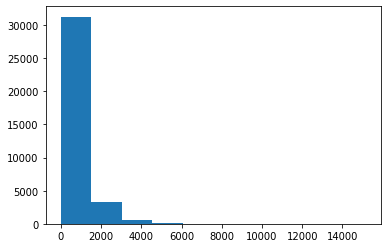

In [74]:
plt.hist(degrees.values())
plt.show()

In [75]:
project.head(3)

,id,acronym,status,title,startDate,endDate,totalCost,ecMaxContribution,legalBasis,topics,...,fundingScheme,nature,objective,contentUpdateDate,rcn,grantDoi,Community,New_Community,New_Community_Name,Degree
0,817296,eDCaseMAN,CLOSED,"Defendable legal cases through an affordable, ...",2018-05-01,2018-09-30,71429,50000,H2020-EU.2.3.,EIC-SMEInst-2018-2020,...,SME-1,NaN,"""Electronic discovery (known as e-discovery) i...",2022-08-10 13:07:21,217713,10.3030/817296,0,-99,14,0
1,764717,WinWind,CLOSED,Winning social acceptance for wind energy in w...,2017-10-01,2020-03-31,"2124462,5","2124462,5",H2020-EU.3.3.,LCE-21-2017,...,CSA,NaN,The overall objective of WinWind is to enhance...,2022-08-17 10:54:17,211548,10.3030/764717,1,1,0,427
2,784994,PentaHelix,CLOSED,Multi stakeholder and governance approach for ...,2018-03-01,2021-09-30,"1808343,75","1808343,75",H2020-EU.3.3.,EE-09-2016-2017,...,CSA,NaN,The PentaHelix project is focusing on developi...,2022-04-11 16:42:12,213566,10.3030/784994,1,1,0,74


In [76]:
# Trop long a faire tourner

# clustering_coef = nx.clustering(G)
# clustering_coef

In [77]:
degree_centrality = nx.degree_centrality(G)

In [78]:
project = dict_to_df(degree_centrality, project, "Degree_Centrality", dtype="float64")

In [79]:
project.head(2)

,id,acronym,status,title,startDate,endDate,totalCost,ecMaxContribution,legalBasis,topics,...,nature,objective,contentUpdateDate,rcn,grantDoi,Community,New_Community,New_Community_Name,Degree,Degree_Centrality
0,817296,eDCaseMAN,CLOSED,"Defendable legal cases through an affordable, ...",2018-05-01,2018-09-30,71429,50000,H2020-EU.2.3.,EIC-SMEInst-2018-2020,...,NaN,"""Electronic discovery (known as e-discovery) i...",2022-08-10 13:07:21,217713,10.3030/817296,0,-99,14,0,0.000000
1,764717,WinWind,CLOSED,Winning social acceptance for wind energy in w...,2017-10-01,2020-03-31,"2124462,5","2124462,5",H2020-EU.3.3.,LCE-21-2017,...,NaN,The overall objective of WinWind is to enhance...,2022-08-17 10:54:17,211548,10.3030/764717,1,1,0,427,0.012069


Centralité de proximité : cette méthode calcule la centralité d'un noeud en fonction de la distance moyenne à tous les autres noeuds. Plus un noeud est proche des autres noeuds, plus sa centralité est élevée.

In [80]:
# Trop long a faire tourner

# closeness_centrality = nx.closeness_centrality(G)

Centralité de betweenness : cette méthode calcule la centralité d'un noeud en fonction de sa participation aux chemins les plus courts entre tous les autres noeuds. Plus un noeud est sur des chemins courts entre les autres noeuds, plus sa centralité est élevée.

In [81]:
# Trop long a faire tourner

# betweenness_centrality = nx.betweenness_centrality(G)

Centralité de eigenvector : cette méthode calcule la centralité d'un noeud en fonction de la centralité de ses voisins. Les noeuds connectés à des noeuds centraux auront une centralité plus élevée.

In [82]:
# Trop long a faire tourner

# eigenvector_centrality = nx.eigenvector_centrality(G)

## C- Calcules sur les partitions

Nouvelle méthode de création de sous-graphe en fonction de leur communauté 

In [83]:
# for group in set(nx.get_node_attributes(G, 'New_Community_Name').values()):
#     nodes = [n for n, attrdict in G.nodes(data=True) if attrdict['New_Community_Name'] == group]
#     subgraph = G.subgraph(nodes)
#     print("Sous-graphe pour le groupe", group)
#     print(subgraph.nodes(data=True))
#     print("")

On inverse le dictionnaire des partitions

In [84]:
from collections import defaultdict

new_partition = project.set_index('id')["New_Community_Name"].to_dict()
inverted_dict = defaultdict(list)

for key, value in new_partition.items():
    inverted_dict[value].append(key)

In [85]:
subgraphs = {}
for partition_name, nodes in inverted_dict.items():
    subgraphs[partition_name] = nx.induced_subgraph(G, nodes)

In [86]:
subgraphs.keys()

dict_keys([14, 0, 6, 1, 10, 7, 9, 5, 4, 8, 3, 11, 12, 13, 2])

In [133]:
for key in subgraphs.keys():
    print(f"Partition: {key} | Nodes' number: {subgraphs[key].number_of_nodes()} | Edges' number: {subgraphs[key].number_of_edges()}")
    nx.write_gexf(subgraphs[key], f"../graphs_save/subgraph_partition_{key}.gexf")

Partition: 14 | Nodes' number: 5279 | Edges' number: 13258
Partition: 0 | Nodes' number: 7887 | Edges' number: 1565635
Partition: 6 | Nodes' number: 1920 | Edges' number: 211678
Partition: 1 | Nodes' number: 3541 | Edges' number: 499172
Partition: 10 | Nodes' number: 4934 | Edges' number: 572131
Partition: 7 | Nodes' number: 1689 | Edges' number: 100232
Partition: 9 | Nodes' number: 2428 | Edges' number: 1639611
Partition: 5 | Nodes' number: 1782 | Edges' number: 126960
Partition: 4 | Nodes' number: 972 | Edges' number: 121746
Partition: 8 | Nodes' number: 1034 | Edges' number: 85722
Partition: 3 | Nodes' number: 1489 | Edges' number: 230279
Partition: 11 | Nodes' number: 443 | Edges' number: 76436
Partition: 12 | Nodes' number: 562 | Edges' number: 70680
Partition: 13 | Nodes' number: 535 | Edges' number: 31510
Partition: 2 | Nodes' number: 886 | Edges' number: 239779


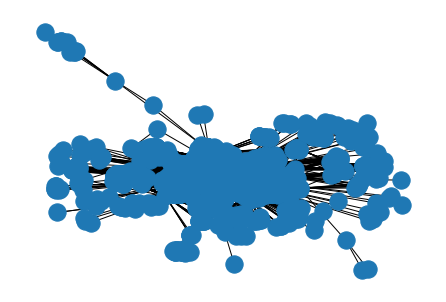

In [88]:
import random
nx.draw(subgraphs[random.choice(list(subgraphs.keys()))])

In [89]:
graph_options = {
    'node_color': 'lightblue',
    'node_size' : 10,
    "edge_color": 'yellow'
}

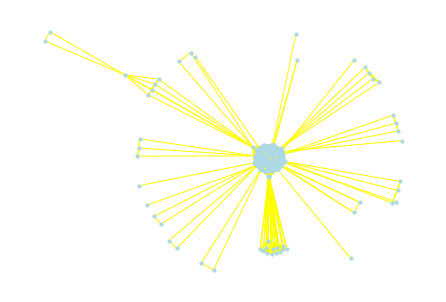

In [90]:
nx.draw(subgraphs[11], **graph_options)

In [91]:
part_metrics = {key:{"density":nx.density(subgraphs[key])} for key in subgraphs.keys()}

In [92]:
part_metrics = {}

for key in subgraphs.keys():
    part_metrics[key] = {
        "density": round(nx.density(subgraphs[key]), 4),
        "mean_degree": round(sum(dict(nx.degree(subgraphs[key])).values()) / subgraphs[key].number_of_nodes(), 4)
#         "mean_subgraph_centrality": round(sum(dict(nx.subgraph_centrality(subgraphs[key])).values()) / subgraphs[key].number_of_nodes(), 4)
#         "tansitity": nx.transitivity(subgraphs[key]) # prend trop de temps
#         "centrality": nx.closeness_centrality(subgraphs[key]) # prend trop de temps
    }

In [93]:
part_metrics

{14: {'density': 0.001, 'mean_degree': 5.0229},
 0: {'density': 0.0503, 'mean_degree': 397.0166},
 6: {'density': 0.1149, 'mean_degree': 220.4979},
 1: {'density': 0.0796, 'mean_degree': 281.9384},
 10: {'density': 0.047, 'mean_degree': 231.9137},
 7: {'density': 0.0703, 'mean_degree': 118.688},
 9: {'density': 0.5565, 'mean_degree': 1350.5857},
 5: {'density': 0.08, 'mean_degree': 142.4916},
 4: {'density': 0.258, 'mean_degree': 250.5062},
 8: {'density': 0.1605, 'mean_degree': 165.8066},
 3: {'density': 0.2079, 'mean_degree': 309.3069},
 11: {'density': 0.7807, 'mean_degree': 345.0835},
 12: {'density': 0.4484, 'mean_degree': 251.5302},
 13: {'density': 0.2206, 'mean_degree': 117.7944},
 2: {'density': 0.6116, 'mean_degree': 541.2619}}

---

# IV- Importation des données de publications

In [94]:
%cd Notebook/

[WinError 2] Le fichier spécifié est introuvable: 'Notebook/'
C:\Users\Marin\Desktop\Cours\M2\S1\Projet tuteuré\Cordis\Notebook


In [95]:
publication_0 = pd.read_csv("../Data/CSV/Publications/projectPublications.csv", sep=";")
publication_1 = pd.read_csv("../Data/CSV/Publications/projectPublications_2.csv", sep=";")
publication_2 = pd.read_csv("../Data/CSV/Publications/projectPublications_3.csv", sep=";")
publication_3 = pd.read_csv("../Data/CSV/Publications/projectPublications_4.csv", sep=";")
publication_4 = pd.read_csv("../Data/CSV/Publications/projectPublications_5.csv", sep=";")
publication_5 = pd.read_csv("../Data/CSV/Publications/projectPublications_6.csv", sep=";")

In [96]:
print(publication_0.shape)
print(publication_1.shape)
print(publication_2.shape)
print(publication_3.shape)
print(publication_4.shape)
print(publication_5.shape)

(55001, 16)
(55001, 16)
(55001, 16)
(55001, 16)
(55001, 16)
(26586, 16)


In [97]:
publications_list = [publication_0,
publication_1,
publication_2,
publication_3,
publication_4,
publication_5]

On fusionne tous les dataframes en un seul

In [98]:
publication = pd.DataFrame()
for publi in publications_list:
    publication = pd.concat([publication, publi], axis=0)

## A- Informations sur les données

In [99]:
publication.shape

(301591, 16)

In [100]:
publication.head()

,id,title,isPublishedAs,authors,journalTitle,journalNumber,publishedYear,publishedPages,issn,isbn,doi,projectID,projectAcronym,collection,contentUpdateDate,rcn
0,823965_1537977_PUBLI,On the Utility of High-Resolution Soil Moistur...,Peer reviewed articles,"Ait Hssaine, B.; Chehbouni, A.; Er-Raki, S.; K...",Remote Sensing,NaN,2021.0,NaN,2072-4292,NaN,10.3390/rs13040727,823965,ACCWA,Project publication,2022-09-27 18:18:00,872894
1,764958_1538020_PUBLI,Thermosensitive hydration of four acrylamide-b...,Peer reviewed articles,"Patrick K. Quoika, Maren Podewitz, Yin Wang, A...",The Journal of Physical Chemistry B,2,2020.0,9745 - 9756,1520-5207,NaN,10.1021/acs.jpcb.0c07232,764958,NANOSTEM,Project publication,2022-09-27 18:20:01,872958
2,677120_355435_PUBLI,On property (T) for Aut(F_n) and SL_n(Z),Peer reviewed articles,"Marek Kaluba, Dawid Kielak, Piotr W. Nowak",Annals of Mathematics,"Volume 193 (2021), Issue 2",2018.0,539-562,0003-486X,NaN,10.4007/annals.2021.193.2.3,677120,INDEX,Project publication,2022-09-30 20:15:15,544507
3,761042_1539423_PUBLI,Sporulation in solventogenic and acetogenic cl...,Peer reviewed articles,Mamou Diallo; Servé W. M. Kengen; Ana M. López...,Applied Microbiology and Biotechnology,105,2021.0,3533-3557,0175-7598,NaN,10.1007/s00253-021-11289-9,761042,BIOCONCO2,Project publication,2022-09-27 18:19:56,872951
4,871037_1533329_PUBLI,Comprehensive Fragment Screening of the SARS-C...,Peer reviewed articles,"Berg H, Wirtz Martin MA, Altincekic N, Alshaml...",Angew Chem Int Ed Engl.,NaN,2022.0,NaN,1433-7851,NaN,10.1002/anie.202205858,871037,iNEXT-Discovery,Project publication,2022-09-30 20:17:09,870820


## B- Traitement sur les données

On calcule le nombre de publications pour chaque projectID

In [101]:
print(len(list(publication["projectID"].value_counts().index)))
pub_project = publication["projectID"].value_counts().to_dict()

19395


In [102]:
pub_project

{633053: 6196,
 681202: 1593,
 696656: 942,
 785219: 876,
 785907: 607,
 881603: 554,
 665778: 512,
 669026: 461,
 654109: 441,
 945539: 428,
 654002: 414,
 654148: 414,
 739551: 409,
 739508: 379,
 692419: 379,
 654305: 378,
 690575: 376,
 643417: 361,
 641816: 351,
 689443: 327,
 789028: 307,
 668995: 305,
 870628: 304,
 761727: 304,
 727872: 295,
 830927: 293,
 654360: 289,
 823717: 279,
 727987: 275,
 663830: 269,
 720270: 267,
 633531: 266,
 654208: 263,
 681228: 251,
 730960: 249,
 654024: 248,
 643476: 243,
 678024: 240,
 692145: 239,
 641122: 238,
 730872: 231,
 664931: 231,
 688995: 230,
 824093: 223,
 633595: 220,
 739593: 218,
 692146: 218,
 691135: 216,
 739582: 215,
 694097: 214,
 713279: 213,
 871149: 211,
 691818: 210,
 713673: 210,
 653706: 207,
 777826: 207,
 692194: 206,
 734922: 205,
 690904: 203,
 691714: 202,
 654168: 201,
 692022: 200,
 712949: 200,
 666881: 199,
 668981: 199,
 733206: 199,
 952215: 198,
 678760: 195,
 713683: 193,
 810980: 192,
 741520: 191,
 817

In [103]:
id_project_publi = list(pub_project.keys())
print(len(id_project_publi))

19395


In [104]:
project[project["id"].isin(id_project_publi)].head(3)

,id,acronym,status,title,startDate,endDate,totalCost,ecMaxContribution,legalBasis,topics,...,nature,objective,contentUpdateDate,rcn,grantDoi,Community,New_Community,New_Community_Name,Degree,Degree_Centrality
1,764717,WinWind,CLOSED,Winning social acceptance for wind energy in w...,2017-10-01,2020-03-31,"2124462,5","2124462,5",H2020-EU.3.3.,LCE-21-2017,...,NaN,The overall objective of WinWind is to enhance...,2022-08-17 10:54:17,211548,10.3030/764717,1,1,0,427,0.012069
3,841546,RES,TERMINATED,Rights for Ecosystem Services (RES): a framewo...,2020-01-13,2022-01-12,"224933,76","224933,76",H2020-EU.1.3.,MSCA-IF-2018,...,NaN,Is currentIs current legal protection adequate...,2021-12-30 09:44:32,222283,10.3030/841546,1,1,0,141,0.003985
4,716923,LEVIATHAN,CLOSED,Taming the Leviathan? Legal and Political Acco...,2017-08-01,2022-01-31,1184595,1184595,H2020-EU.1.1.,ERC-2016-STG,...,NaN,The Euro Crisis has had a transformative effec...,2022-09-08 18:14:15,206991,10.3030/716923,9,9,6,9,0.000254


Nous n'avons pas tous les ID des projets car ne sont renseignés que les projets ayant publiés. 

In [105]:
def fill_publication(publi: dict, project_id: list):

    for project in project_id:
        if project in list(publi.keys()):
            continue
        else: 
            publi[project] = 0


In [106]:
fill_publication(pub_project, project_id)

La fonction ressortait un ID supplémentaire par rapport au nombre d'ID de projets qui nous avions. <br>
Voici un petit moyent de trouver quel ID est en trop et le supprimer

In [107]:
# Trouver l'ID du projet en trop
count = 0
to_delete = []
for intru in list(pub_project.keys()):
    if intru in project_id:
        continue
#         count += 1
    else: 
        to_delete.append(intru)
        print(to_delete)

[743165]


In [108]:
# Suppression de ce projet

# del pub_project[743165]
del pub_project[to_delete[0]]

On va ajouter le nombre de publications par projet

In [109]:
# Quid d'avoir le nomnbre de publications pour faire le graphe ? Cela pourrait-il influer négativemment sur la pertinence
# de notre étude économétrique ? 

On va l'ajouter à notre DataFrame

In [110]:
project = dict_to_df(pub_project, project, "Nb_Publication")

In [111]:
# project.to_csv("../Data/CSV/Projets_updated.csv", index=False)

In [112]:
project.head(3)

,id,acronym,status,title,startDate,endDate,totalCost,ecMaxContribution,legalBasis,topics,...,objective,contentUpdateDate,rcn,grantDoi,Community,New_Community,New_Community_Name,Degree,Degree_Centrality,Nb_Publication
0,817296,eDCaseMAN,CLOSED,"Defendable legal cases through an affordable, ...",2018-05-01,2018-09-30,71429,50000,H2020-EU.2.3.,EIC-SMEInst-2018-2020,...,"""Electronic discovery (known as e-discovery) i...",2022-08-10 13:07:21,217713,10.3030/817296,0,-99,14,0,0.000000,0
1,764717,WinWind,CLOSED,Winning social acceptance for wind energy in w...,2017-10-01,2020-03-31,"2124462,5","2124462,5",H2020-EU.3.3.,LCE-21-2017,...,The overall objective of WinWind is to enhance...,2022-08-17 10:54:17,211548,10.3030/764717,1,1,0,427,0.012069,4
2,784994,PentaHelix,CLOSED,Multi stakeholder and governance approach for ...,2018-03-01,2021-09-30,"1808343,75","1808343,75",H2020-EU.3.3.,EE-09-2016-2017,...,The PentaHelix project is focusing on developi...,2022-04-11 16:42:12,213566,10.3030/784994,1,1,0,74,0.002092,0


---

# V- Traitement sur le DataFrame | Feature Engineering

On va calculer le temps entres la date de début et de fin du projet

In [113]:
project["Project_Duration"] = (pd.to_datetime(project["endDate"])) - (pd.to_datetime(project["startDate"]))
project["Project_Duration"] = pd.to_numeric(project["Project_Duration"].dt.days, downcast="integer")
# project["Project_Duration"] = project["Project_Duration"].astype("int16")

In [114]:
project.head(2)

,id,acronym,status,title,startDate,endDate,totalCost,ecMaxContribution,legalBasis,topics,...,contentUpdateDate,rcn,grantDoi,Community,New_Community,New_Community_Name,Degree,Degree_Centrality,Nb_Publication,Project_Duration
0,817296,eDCaseMAN,CLOSED,"Defendable legal cases through an affordable, ...",2018-05-01,2018-09-30,71429,50000,H2020-EU.2.3.,EIC-SMEInst-2018-2020,...,2022-08-10 13:07:21,217713,10.3030/817296,0,-99,14,0,0.000000,0,152.0
1,764717,WinWind,CLOSED,Winning social acceptance for wind energy in w...,2017-10-01,2020-03-31,"2124462,5","2124462,5",H2020-EU.3.3.,LCE-21-2017,...,2022-08-17 10:54:17,211548,10.3030/764717,1,1,0,427,0.012069,4,912.0


On va compter le nombre d'organisations par projets

In [115]:
print(len(list(organization["projectID"].value_counts().index)))
orgas_dict = organization["projectID"].value_counts().to_dict()

35381


In [116]:
project = dict_to_df(orgas_dict, project, "Nb_Orga")

On peut aussi compter le nombre d'organisations privées / publiques comme features

In [117]:
project.head(3)

,id,acronym,status,title,startDate,endDate,totalCost,ecMaxContribution,legalBasis,topics,...,rcn,grantDoi,Community,New_Community,New_Community_Name,Degree,Degree_Centrality,Nb_Publication,Project_Duration,Nb_Orga
0,817296,eDCaseMAN,CLOSED,"Defendable legal cases through an affordable, ...",2018-05-01,2018-09-30,71429,50000,H2020-EU.2.3.,EIC-SMEInst-2018-2020,...,217713,10.3030/817296,0,-99,14,0,0.000000,0,152.0,1
1,764717,WinWind,CLOSED,Winning social acceptance for wind energy in w...,2017-10-01,2020-03-31,"2124462,5","2124462,5",H2020-EU.3.3.,LCE-21-2017,...,211548,10.3030/764717,1,1,0,427,0.012069,4,912.0,12
2,784994,PentaHelix,CLOSED,Multi stakeholder and governance approach for ...,2018-03-01,2021-09-30,"1808343,75","1808343,75",H2020-EU.3.3.,EE-09-2016-2017,...,213566,10.3030/784994,1,1,0,74,0.002092,0,1309.0,11


Compter le nombres de nationalités par projet

In [118]:
nationalities = organization.groupby("projectID")
nationalities = nationalities["country"].nunique()

In [119]:
# nationalities["country"].agg(pd.Series.mode)

In [120]:
project = project.join(nationalities, on="id")

In [121]:
project.head(3)

,id,acronym,status,title,startDate,endDate,totalCost,ecMaxContribution,legalBasis,topics,...,grantDoi,Community,New_Community,New_Community_Name,Degree,Degree_Centrality,Nb_Publication,Project_Duration,Nb_Orga,country
0,817296,eDCaseMAN,CLOSED,"Defendable legal cases through an affordable, ...",2018-05-01,2018-09-30,71429,50000,H2020-EU.2.3.,EIC-SMEInst-2018-2020,...,10.3030/817296,0,-99,14,0,0.000000,0,152.0,1,1
1,764717,WinWind,CLOSED,Winning social acceptance for wind energy in w...,2017-10-01,2020-03-31,"2124462,5","2124462,5",H2020-EU.3.3.,LCE-21-2017,...,10.3030/764717,1,1,0,427,0.012069,4,912.0,12,6
2,784994,PentaHelix,CLOSED,Multi stakeholder and governance approach for ...,2018-03-01,2021-09-30,"1808343,75","1808343,75",H2020-EU.3.3.,EE-09-2016-2017,...,10.3030/784994,1,1,0,74,0.002092,0,1309.0,11,5


In [122]:
def regularisation(x):
    
    return x.replace(",", ".")

In [123]:
project['totalCost'] = project['totalCost'].apply(regularisation)
project['totalCost'] = project['totalCost'].astype("float64")

In [124]:
project['ecMaxContribution'] = project['ecMaxContribution'].apply(regularisation)
project['ecMaxContribution'] = project['ecMaxContribution'].astype("float64")

On va récupérer le pays de l'organisation coordinatrice

In [126]:
coordinator = organization.loc[organization['role'] == 'coordinator', ['projectID', 'country']]

In [127]:
coordinator.rename(columns={'projectID':"id", "country":"Cor_Country"}, inplace=True)

In [128]:
coordinator

,id,Cor_Country
0,817296,CH
10,764717,DE
22,784994,HR
24,841546,UK
25,716923,DE
...,...,...
177184,728611,UK
177186,711323,ES
177187,837501,SE
177188,952030,HR


In [129]:
project = pd.merge(project, coordinator, on="id")

*Ne fonctionne pas il y a 107 NA dans netEcContribution* <br>
On va essayer de récupérer le pays de l'organisation ayant le plus participé en terme monétaire au projet <br>
Pour cela il faut nettoyer *totalCost* en enlevant les NA, les str vides, changer ',' et '.' et passer le tout en float

In [130]:
organization['Net_Contribution'] = organization['netEcContribution'] - organization['totalCost']

# Groupement par projectID
df_grouped = organization.groupby(['projectID'])

# Trouver l'index de la ligne où la différence est la plus élevée pour chaque groupe
max_diff_index = df_grouped['difference'].idxmax()

# Utilisation de cet index pour sélectionner les lignes correspondantes
result = organization.loc[max_diff_index, ['projectID', 'country']]

TypeError: unsupported operand type(s) for -: 'float' and 'str'

---

# VI- Visualisation

In [ ]:
project_encoded = pd.get_dummies(project_tmp, columns=["status"])

In [ ]:
%cd ..
%cd Scripts/
from mannwhitney_test import mannwhitney_u_test
%cd ..
%cd Notebook

In [ ]:
res = mannwhitney_u_test(project_tmp.drop(columns=['id', 'acronym', 'status', 'title', 'startDate', 'endDate', 
       'legalBasis', 'topics', 'ecSignatureDate',
       'frameworkProgramme', 'masterCall', 'subCall', 'fundingScheme',
       'nature', 'objective', 'contentUpdateDate', 'rcn', 'grantDoi']))

In [ ]:
project.head(3)

In [ ]:
project.columns

In [ ]:
project["nature"]

In [108]:
def saveXLSX(dictionary: dict): 
    sheets = list(dictionary.keys())

    name = "../Data/clustering.xlsx"

    with pd.ExcelWriter(name, engine="xlsxwriter") as writer: 
        for sheet in sheets:
            sheets_name = "Cluster_" + str(sheet)
            dictionary[sheet].to_excel(writer, sheet_name=sheets_name, startcol=0)

In [109]:
saveXLSX(res)

On discrétise le cout des projets pour afficher leur distribution

In [ ]:
project['cost_interval'] = pd.qcut(project['totalCost'], q=10)

In [ ]:
import matplotlib.pyplot as plt

project['cost_interval'].value_counts().sort_index().plot.bar()
plt.xlabel('Cost Interval')
plt.ylabel('Frequency')
plt.show()


In [ ]:
project['totalCost'].plot.density()
plt.xlabel('Cost')
plt.ylabel('Density')
plt.show()

Calcule et affichage de la matrice de corrélationd des variables numériques.

In [ ]:
corr_matrix = project.drop(columns=['id', 'acronym', 'status', 'title', 'startDate', 'endDate', 
       'legalBasis', 'topics', 'ecSignatureDate',
       'frameworkProgramme', 'masterCall', 'subCall', 'fundingScheme',
       'nature', 'objective', 'contentUpdateDate', 'rcn', 'grantDoi']).corr()

In [ ]:
plt.figure(figsize=(14, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.show()

---

# VII- R&D part

Import des packages

In [ ]:
# !pip install gensim
# !pip install nltk

In [116]:
%cd ..
%cd Scripts/
from topic_modeling import topicModeling
%cd ..
%cd Notebook

C:\Users\Marin\Desktop\Cours\M2\S1\Projet tuteuré
C:\Users\Marin\Desktop\Cours\M2\S1\Projet tuteuré\Scripts


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Marin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Marin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


C:\Users\Marin\Desktop\Cours\M2\S1\Projet tuteuré
C:\Users\Marin\Desktop\Cours\M2\S1\Projet tuteuré\Notebook


In [117]:
project_tmp = pd.read_csv("../Data/CSV/projects_tmp.csv")

In [ ]:
topicModeling(project_tmp, "title")